# EDA and Visualization Final Project

In [1]:
# !git clone https://github.com/secregister01/2020-04-13_COVID19-N20
# !cd DataProcessing
# !./core.sh
# !cd ../Notebooks

In [2]:
import os
os.chdir("../")
import sys
sys.path.insert(0, ".")

from utils import *
from utils.paths import *
import utils.paths as p

In [3]:
import matplotlib.pyplot as plt
import math

In [4]:
def check_tagged_day(region, date):
    '''
    date should be in the format of month/day/20
    for example, March 1, 2020 should be 3/1/20
    '''
    try:
        df = pd.read_csv(f"{p.DRP}/{region}.csv")
        tagged_day = df[df['date'] == date]['tagged_day']
        return tagged_day.values[0]
    except:
        return -1

- This data set contains data over 188 countries and all US states covid 19 data
- I tagged the day as 1 when there are at least 20 cases in each country and 10 in each US state
- Initially, I created the data set with low efficiency. After taking EDA class, I learned some new techniques on DataFrame. So I applied them to the dataset and refactor the code to make it more efficient and succint. Please refer to commit 9d5021386e2b1ae6f83cfebd47e811a9a7e3a0ae for more detailed information.

- Here is the core function of Data Processing

In [5]:
def main():
    '''
    Please do not run the funciton directly in this notebook
    '''
    threshold = int(sys.argv[1])
    create_paths(p.DATE)
    
    global_confirmed = pd.read_csv(global_confirmed_path)
    global_death = pd.read_csv(global_death_path)

    countries = list(set(global_confirmed[CR]))
    countries.sort()

    dates = list(global_confirmed.columns)[START:]


    if len(global_death) != len(global_confirmed):
        print("Number of Country Error")

    check_country = global_death['Country/Region'] == global_confirmed['Country/Region']

    if False in list(check_country):
        print("Country not one-to-one Error")

    check_col = global_death.columns == global_confirmed.columns

    if False in check_col:
        print("Column different Error")

    df_global_confirmed_group = global_confirmed.groupby(CR).sum().drop(columns=["Lat", "Long"]).transpose()
    df_global_death_group = global_death.groupby(CR).sum().drop(columns=["Lat", "Long"]).transpose()
    date = df_global_confirmed_group.index
    
    for country in countries:
        confirmed = df_global_confirmed_group[country]
        deaths = df_global_death_group[country]
        new_confirmed = misplaced_subtraction(confirmed)
        new_deaths = misplaced_subtraction(deaths)
        d = {"country": country, "date":date, "confirmed": confirmed, "deaths": deaths,
            "new_confirmed":new_confirmed, "new_deaths":new_deaths}
        df = pd.DataFrame(data=d)

        df = df[df["confirmed"] > threshold]

        df["tagged_day"] = range(1,len(df)+1)
        df.to_csv(f"{p.DRP}/{country}.csv", index=False)

- Look at sample data

In [6]:
create_paths("DateWorld")
df_test = pd.read_csv(f"{p.DRP}/US.csv")
df_test.head()

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day
0,US,2/29/20,25,1,8,1,1
1,US,3/1/20,32,1,7,0,2
2,US,3/2/20,55,6,23,5,3
3,US,3/3/20,74,7,19,1,4
4,US,3/4/20,107,11,33,4,5


# Plot Redesign
- Here is the [previous Plots](https://github.com/secregister01/2020-04-13_COVID19-N20/blob/master/Notebooks/Covid19-N20.ipynb) I created in the COVID19-N20 Project, showing new daily confirmed cases in different countries
![](previous/001.png)
- The problem here is there are too many countries, too many colors, too many up and downs. So people will feel uncomfortable when seeing this picture.
- To redesign this picture, I decide only to plot one country, say US, in the plot. Annotating events that lead to "peaks" of new confirmed cases.
- Here is the code

In [7]:
create_paths("DateWorld")
countries, index_country, country_index = get_countries()
selected_countries = [country_index[country] for country in ["US"]]

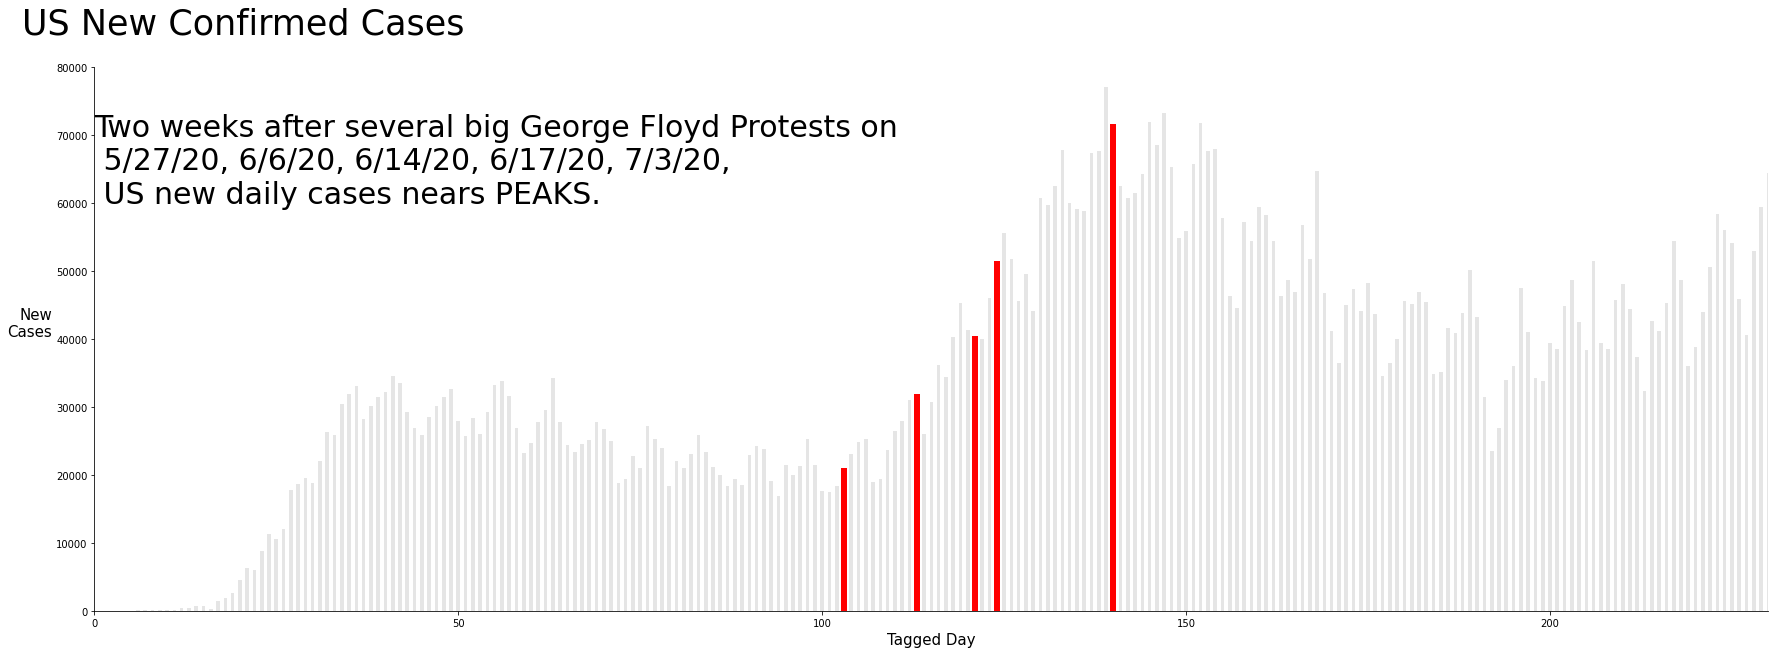

In [8]:
plot_size_x = 30
plot_size_y = 10

n = len(selected_countries)
n_row = n
n_col = 1

fig, ax = plt.subplots(1,1, figsize=(plot_size_x, plot_size_y), sharex=True, sharey=True)

for i in range(n):
    
    ax.set_xlim(0,230)
    ax.set_ylim(0,80000)
    #ax = axes.pop(0)
    country_index = selected_countries[i]
    country = index_country[country_index]
    df = pd.read_csv(f"{p.DRP}/{country}.csv")
    
    tagged_day = df['tagged_day']
    cum_cases = df["new_confirmed"]
    
    ax.text(-10, 85_000, f"{country} New Confirmed Cases", fontsize=35)
    ax.set_xlabel("Tagged Day", fontsize=15)
    ax.set_ylabel("New\nCases", rotation=0, horizontalalignment='right', fontsize=15)
    ax.bar(tagged_day, cum_cases, width=0.5, color='grey', alpha=0.2)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if country == "US":
        key_dates = ['5/27/20','6/6/20', '6/14/20', '6/17/20', '7/3/20']
        key_tagged_day = [check_tagged_day(country, date)+14 for date in key_dates]
        new_cases = [df[df['tagged_day']==tagged_day]['new_confirmed'].values[0] for tagged_day in key_tagged_day]
        ax.bar(key_tagged_day, new_cases, color='red')
        ax.text(0, 60000, f"Two weeks after several big George Floyd Protests on\n {', '.join(key_dates)},\n {country} new daily cases nears PEAKS.",
               fontsize=30, horizontalalignment='left')
    
    
plt.show()

- [Reference for key date of George Floyd Protests in US](https://en.wikipedia.org/wiki/George_Floyd_protests)

- For US States, I do the same thing

In [9]:
create_paths("DateUS")
states, index_states, states_index = get_us_states()
selected_states = [states_index[state] for state in ['California', 'Texas', 'Florida']]

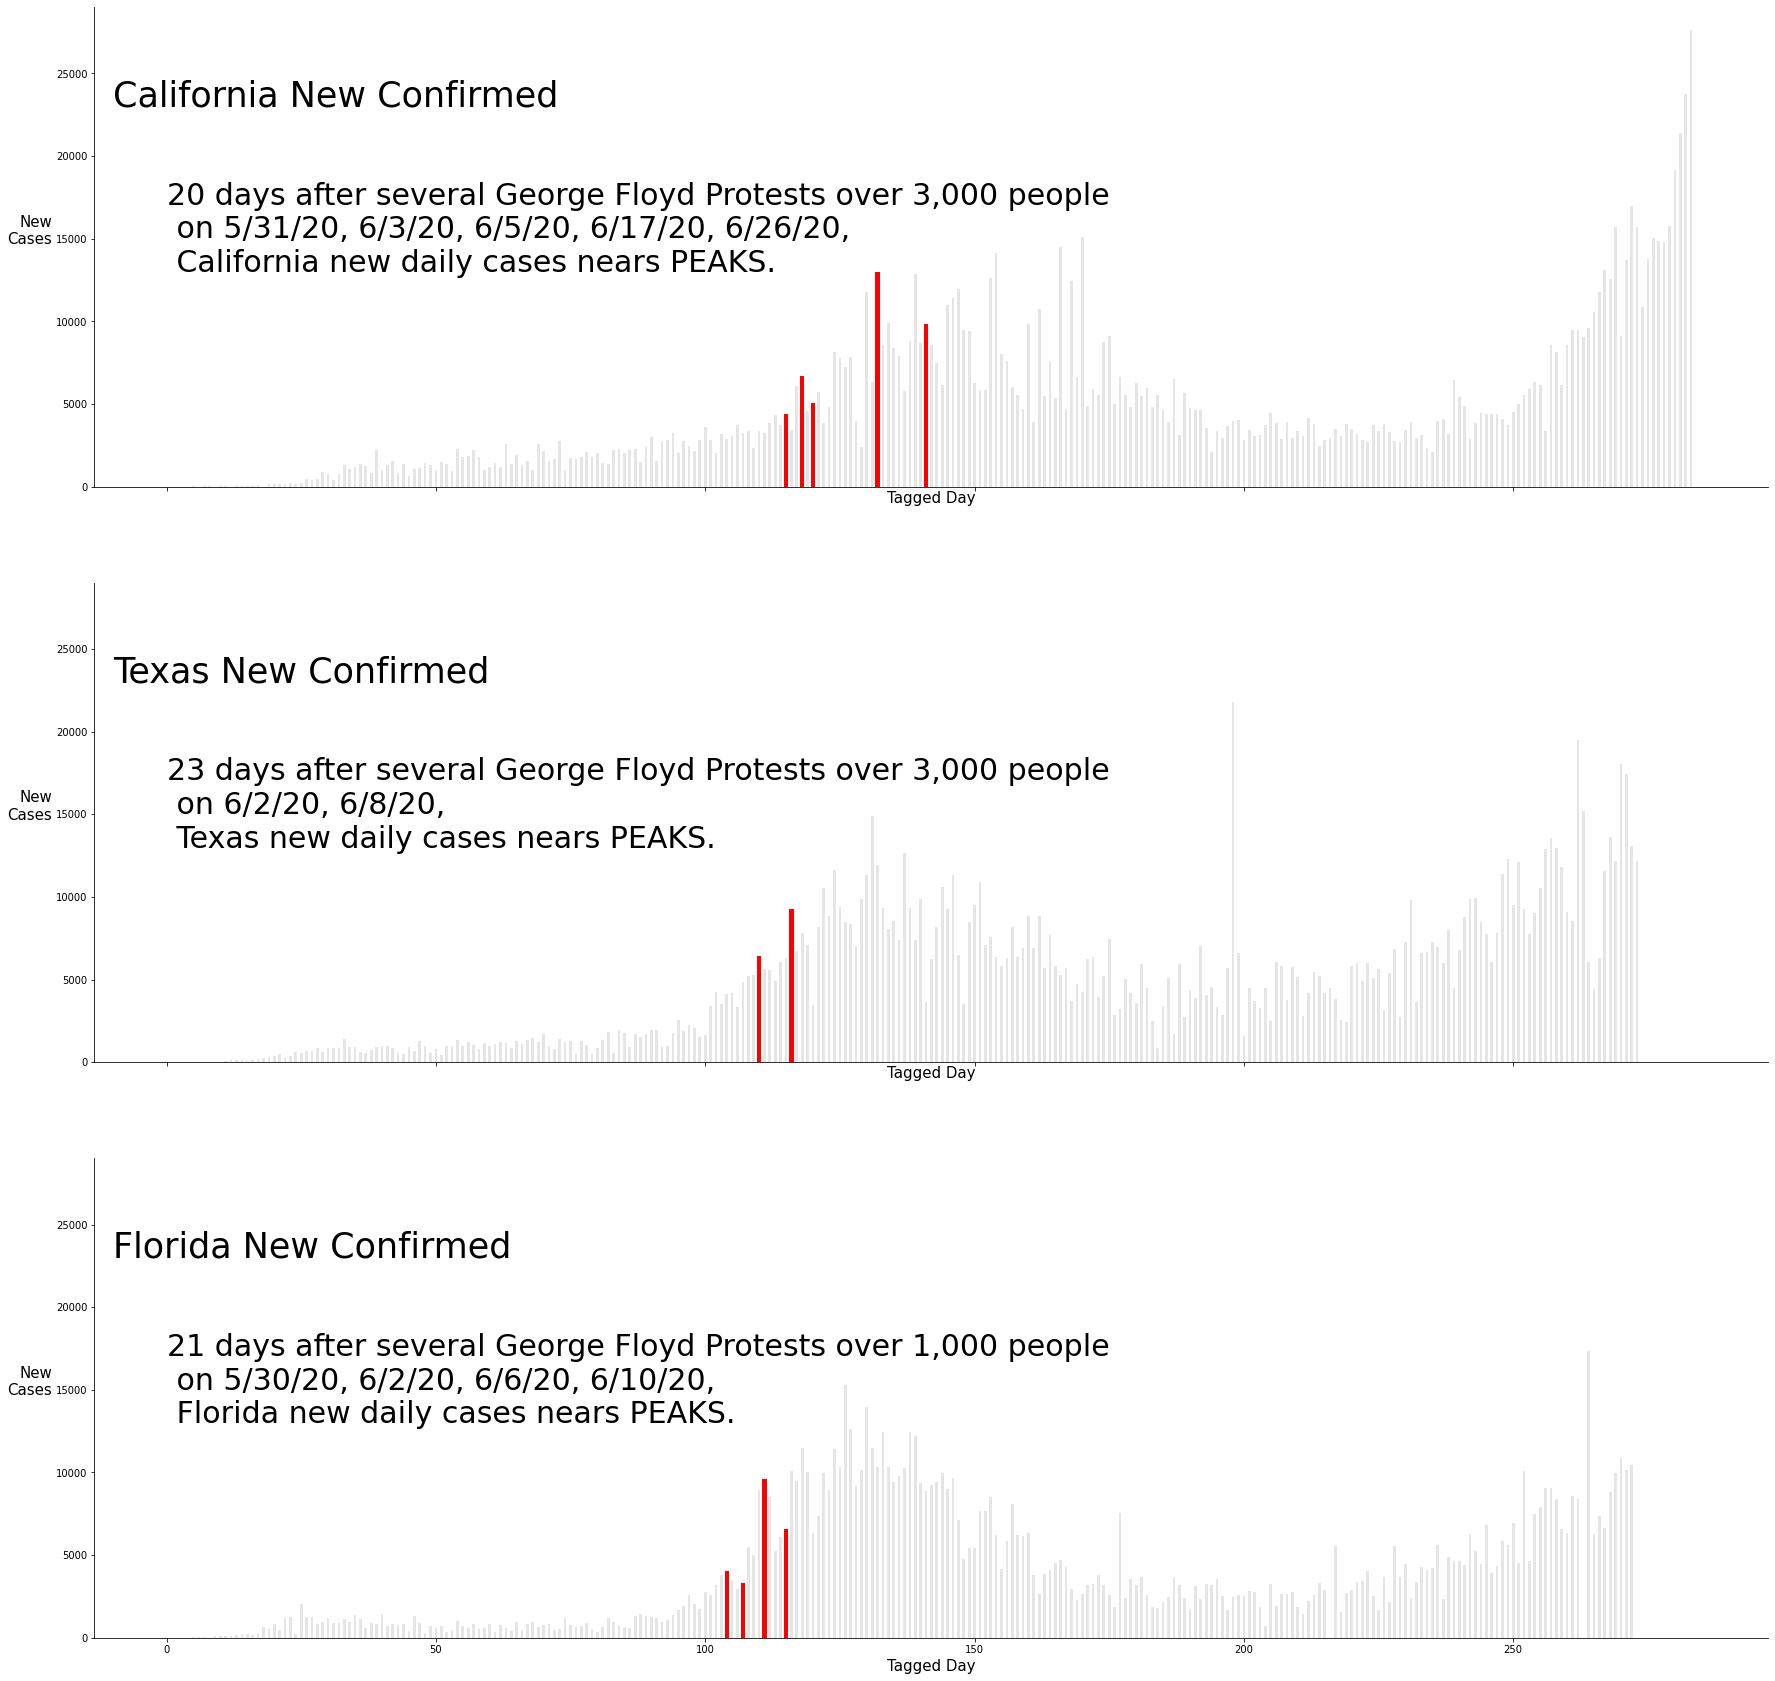

In [10]:
plot_size_x = 30
plot_size_y = 10

n = len(selected_states)
n_row = n
n_col = 1

fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*plot_size_x, n_row*plot_size_y), sharex=True, sharey=True)

for i in range(n):
    ax = axes[i]
    state_index = selected_states[i]
    state = index_states[state_index]
    df = pd.read_csv(f"{p.DRP}/{state}.csv")
    
    tagged_day = df['tagged_day']
    cum_cases = df["new_confirmed"]
    
    ax.text(-10, 23000, f"{state} New Confirmed", fontsize=35)
    ax.set_xlabel("Tagged Day", fontsize=15)
    ax.set_ylabel("New\nCases", rotation=0, horizontalalignment='right', fontsize=15)
    ax.bar(tagged_day, cum_cases,width=0.5, color='grey', alpha=0.2)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if state == "California":
        key_dates = ['5/31/20', '6/3/20','6/5/20', '6/17/20', '6/26/20']
        key_tagged_day = [check_tagged_day(state, date)+20 for date in key_dates]
        new_cases = [df[df['tagged_day']==tagged_day]['new_confirmed'].values[0] for tagged_day in key_tagged_day]
        ax.bar(key_tagged_day, new_cases, color='red')
        ax.text(0, 13000, f"20 days after several George Floyd Protests over 3,000 people\n on {', '.join(key_dates)},\n {state} new daily cases nears PEAKS.",
               fontsize=30, horizontalalignment='left')
        
    if state == "Texas":
        key_dates = ['6/2/20', '6/8/20']
        key_tagged_day = [check_tagged_day(state, date)+23 for date in key_dates]
        new_cases = [df[df['tagged_day']==tagged_day]['new_confirmed'].values[0] for tagged_day in key_tagged_day]
        ax.bar(key_tagged_day, new_cases, color='red')
        ax.text(0, 13000, f"23 days after several George Floyd Protests over 3,000 people\n on {', '.join(key_dates)},\n {state} new daily cases nears PEAKS.",
               fontsize=30, horizontalalignment='left')
        
    if state == "Florida":
        key_dates = ['5/30/20', '6/2/20', '6/6/20', '6/10/20']
        key_tagged_day = [check_tagged_day(state, date)+21 for date in key_dates]
        new_cases = [df[df['tagged_day']==tagged_day]['new_confirmed'].values[0] for tagged_day in key_tagged_day]
        ax.bar(key_tagged_day, new_cases, color='red')
        ax.text(0, 13000, f"21 days after several George Floyd Protests over 1,000 people\n on {', '.join(key_dates)},\n {state} new daily cases nears PEAKS.",
               fontsize=30, horizontalalignment='left')

plt.show()

- We can see from the previous plots, after two weeks to one months of large protesting, the new cases are near corrsponding "peaks".
- We need to avoid large social get togethers during the COVID-19 Pandemic

- [California Protest Data](https://en.wikipedia.org/wiki/George_Floyd_protests_in_California)
- [Texas Protest Data](https://en.wikipedia.org/wiki/George_Floyd_protests_in_Texas)
- [Florida Protest Data](https://en.wikipedia.org/wiki/George_Floyd_protests_in_Florida)

- I redesign this plot from [1Point3Acres](https://coronavirus.1point3acres.com/zh?from=timeline&isappinstalled=0)
 ![](previous/002.png)

- This Picture has many informations. It is also a dynamic picture showing the change of "ranking" in each US state.
- However, too many colors is attention distracting.
- I redesign this picture for countries instead of US states. Showing only the top 4 cumulative cases in the world, in which US is top 1.
- I make US the "attention" with thick red lines. Other countries are in blue, and transparent lines.
- My picture make comparisons with same inial cases, that is, 20. 
- I plot each day from day 1 to day 200, then make a gif

- Here is the code to generate each picture

In [13]:
create_paths("DateWorld")
countries, index_country, country_index = get_countries()
selected_countries = [country_index[country] for country in ['US', 'Brazil', 'India', 'Russia']]

In [16]:
if 'images' not in os.listdir("Notebooks"):
    os.mkdir("Notebooks/images")

if 'gifs' not in os.listdir("Notebooks"):
    os.mkdir("Notebooks/gifs")

In [17]:
plot_size_x = 30
plot_size_y = 15

n = len(selected_countries)

for nth_tagged_day in range(1,201):
    fig, ax = plt.subplots(1,1, figsize=(plot_size_x, plot_size_y))
    ax.set_xlim(0,201)
    ax.set_ylim(0, 7e6)

    for i in range(n):

        country_index = selected_countries[i]
        country = index_country[country_index]
        df = pd.read_csv(f"{p.DRP}/{country}.csv")
        df = df[:nth_tagged_day]

        tagged_day = df['tagged_day']
        cum_cases = df["confirmed"]

        color = 'blue'
        alpha = 0.1
        line_width = 1
        s = 70
        if country == 'US':
            color = 'red'
            alpha = 1
            line_width = 5
            s = 90
        ax.plot(tagged_day, cum_cases, color=color, alpha=alpha, linewidth=line_width)
        
        max_x = tagged_day.values[len(tagged_day)-1]
        max_y = cum_cases.values[len(cum_cases)-1]
        
        ax.scatter(max_x, max_y, s=s, color=color, alpha=alpha)
        ax.text(max_x+2, max_y, country, fontsize=20, color=color)

    #ax.set_title(country)

    ax.set_xlabel("Tagged Day",fontsize=30)
    ax.set_ylabel("Confirmed\nCases", rotation=0, horizontalalignment='right', fontsize=30)
    ax.text(0, 7.5e6, "US Cumulative Cases is the Highest in the World", fontsize=40, horizontalalignment='left')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.savefig(f"Notebooks/images/{str(nth_tagged_day)}.jpg")
    plt.close(fig)

- Here is the gif

In [19]:
# code referenced from: https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python
import imageio
images = []
for i in range(1,201):
    images.append(imageio.imread(f"Notebooks/images/{i}.jpg"))
imageio.mimsave('Notebooks/gifs/002.gif', images)

![](gifs/002.gif)